<a href="https://colab.research.google.com/github/JoseConder/DS_proyecto3/blob/main/Lenguaje_Natural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

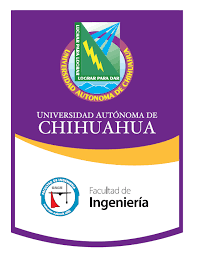

Universidad Autónoma de Chihuahua - Facultad de Ingenieríá

Data Science

Uso de machine Learning con Lenguaje Natural

José Eduardo Conde Hernández 299506

Docente: Jesús Roberto López Santillan


**Implementación de RNN para uso de fragmentos de texto de Shakespeare**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, GRU, InputLayer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import numpy as np
import os


In [ ]:
shakespeare_url = "https://homl.info/shakespeare"
filepath = tf.keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [ ]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [ ]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [ ]:
max_id = len(tokenizer.word_index)
print(max_id)
dataset_size = tokenizer.document_count
dataset_size

47


78278

In [ ]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

In [ ]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [ ]:
n_steps = 100
window_length = n_steps + 1
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [ ]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [ ]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch)
)

dataset = dataset.prefetch(1)

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=20, steps_per_epoch=100)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - loss: 3.2996
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 442ms/step - loss: 2.8879
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 463ms/step - loss: 2.5497
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 441ms/step - loss: 2.4402
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - loss: 2.3511
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 437ms/step - loss: 2.2824
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 463ms/step - loss: 2.2127
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 440ms/step - loss: 2.1825
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 454ms/step - loss: 2.1397
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 442ms/step - loss: 2.1199
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 465ms/step - loss: 2.0736
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 441ms/step - loss: 2.0592
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - loss: 2.0418
Epoch 14/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 446ms/step - loss: 2.0165
Epoch 15/20
100

In [ ]:
def process(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)



In [ ]:
x_new = process(["How are yo"])
y_prob = model.predict(x_new)
y_pred = np.argmax(y_prob, axis=-1)
tokenizer.sequences_to_texts(y_pred + 1)[0][-1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


'u'

In [ ]:
def next_char(text, temperature=1):
    X_new = process([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]



In [ ]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [ ]:
print(complete_text("t", temperature=0.2))
print(complete_text("w", temperature=1))
print(complete_text("y", temperature=2))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━

**Implementación de RNN para uso de fragmentos del guión de Star Wars IV: A New Hope**

In [3]:
from google.colab import files

uploaded = files.upload()


Saving starwars_iv.txt to starwars_iv.txt


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, GRU, InputLayer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import numpy as np
import os

with open('starwars_iv.txt', 'r') as file:
    starwars_script = file.read()
print(starwars_script[:500])


"character" "dialogue"
"1" "THREEPIO" "Did you hear that?  They've shut down the main reactor.  We'll be destroyed for sure.  This is madness!"
"2" "THREEPIO" "We're doomed!"
"3" "THREEPIO" "There'll be no escape for the Princess this time."
"4" "THREEPIO" "What's that?"
"5" "THREEPIO" "I should have known better than to trust the logic of a half-sized thermocapsulary dehousing assister..."
"6" "LUKE" "Hurry up!  Come with me!  What are you waiting for?!  Get in gear!"
"7" "THREEPIO" "Artoo! Art


In [7]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(starwars_script)

In [ ]:
tokenizer.texts_to_sequences(["reactor"])

[[9, 2, 7, 20, 4, 5, 9]]

In [8]:
max_id = len(tokenizer.word_index)
print(max_id)
dataset_size = tokenizer.document_count
dataset_size

47


78278

In [9]:
[encoded] = np.array(tokenizer.texts_to_sequences([starwars_script])) - 1

In [10]:
train_size = dataset_size * 90 // 100
print(train_size)
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

70450


In [11]:
n_steps = 100
window_length = n_steps + 1
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

In [12]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [13]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [14]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch)
)

dataset = dataset.prefetch(1)

In [17]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=20, steps_per_epoch=100)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 473ms/step - loss: 3.3956
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 475ms/step - loss: 2.8556
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 451ms/step - loss: 2.4645
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 471ms/step - loss: 2.2514
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 468ms/step - loss: 2.1543
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - loss: 2.1056
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 474ms/step - loss: 2.0724
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 460ms/step - loss: 2.0102
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 474ms/step - loss: 1.9747
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 470ms/step - loss: 1.9473
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - loss: 1.9235
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 473ms/step - loss: 1.8840
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 458ms/step - loss: 1.8769
Epoch 14/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 475ms/step - loss: 1.8062
Epoch 15/20
100

In [18]:
def process(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)



In [19]:
x_new = process(["Did you hear tha"])
y_prob = model.predict(x_new)
y_pred = np.argmax(y_prob, axis=-1)
tokenizer.sequences_to_texts(y_pred + 1)[0][-1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


't'

In [20]:
def next_char(text, temperature=1):
    X_new = process([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]



In [21]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [42]:
print(complete_text("There'll be n", temperature=.25))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━